# ODSC London 22 September - Missing Data Tutorial

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

In most fields, missing data is so common that it is a given. You literally design your studies from the beginning with missing data in mind. The problem is particularly acute for surveys, longitudinal studies, and in clinical medicine.

Overall, handling missing data is so important that (Wainer 2010) considers it one of the “six necessary tools” that researchers need to master in order to successfully tackle problems in their fields in the 21st century.

**Aim of this tutorial**
1. To give you an understanding of missing data and the statistical problems it raises
2. To provide you with a comprehensive, A to Z, applied tutorial on handling missing data


### What is missing data? 

**"Values that are not available and that would be meaningful for analysis if they were observed" (Little 2012)**

When you have missing data for variables that are not of interest in your study, you can consider you do not have missing data. The first step is hence to reduce your dataset to the relevant variables. Then you can start looking at missing data.

In [2]:
# Use Horse Dataset, with 30% missing values
# Description http://archive.ics.uci.edu/ml/datasets/horse+colic
path = "../../data/datasets/horse.csv"
horse_df = pd.read_csv(path, delimiter = ',')

In [3]:
print(len(horse_df))

299


In [4]:
horse_df.head(1)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no


In [5]:
# Can observe already from count that there's 58 values missing for respiratory_rate
horse_df.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2.990000e+02,239.000000,275.000000,241.000000,53.000000,270.000000,266.000000,101.000000,299.000000,299.000000,299.000000
mean,1.087733e+06,38.168619,72.000000,30.460581,4.707547,46.307407,24.274436,3.039604,3659.709030,90.528428,7.387960
std,1.532032e+06,0.733744,28.646219,17.666102,1.982311,10.436743,27.364194,1.967947,5408.472421,650.637139,127.749768
min,5.184760e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000,0.000000,0.000000,0.000000
25%,5.289040e+05,37.800000,48.000000,18.000000,3.000000,38.000000,6.500000,2.000000,2111.500000,0.000000,0.000000
50%,5.303010e+05,38.200000,64.000000,25.000000,5.000000,45.000000,7.500000,2.300000,2322.000000,0.000000,0.000000
75%,5.347360e+05,38.500000,88.000000,36.000000,6.500000,52.000000,56.750000,3.900000,3209.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,7111.000000,2209.000000


In [6]:
horse_df.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities       56
peripheral_pulse          69
mucous_membrane           47
capillary_refill_time     32
pain                      55
peristalsis               44
abdominal_distention      56
nasogastric_tube         104
nasogastric_reflux       106
nasogastric_reflux_ph    246
rectal_exam_feces        102
abdomen                  118
packed_cell_volume        29
total_protein             33
abdomo_appearance        165
abdomo_protein           198
outcome                    0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
dtype: int64

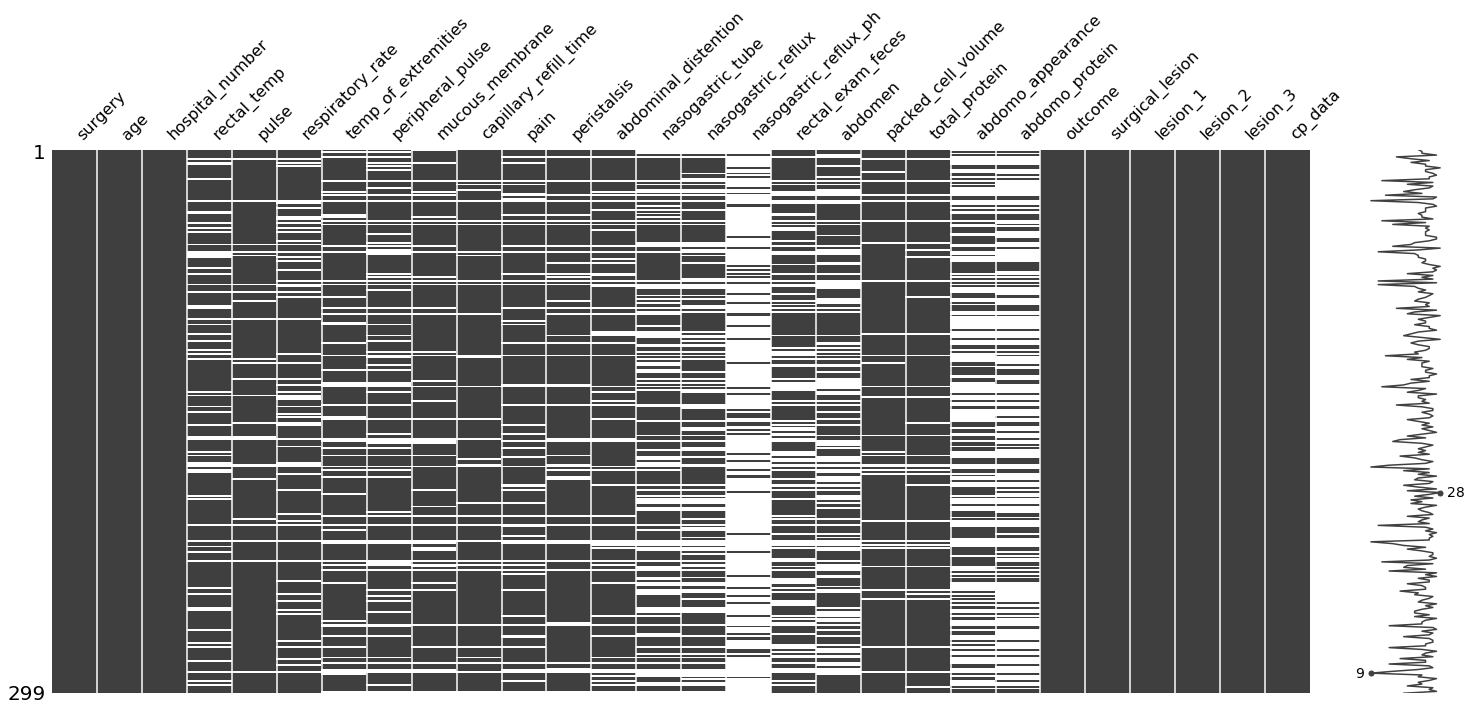

In [7]:
# Use missingno package to visualize missing data
import missingno as msno
msno.matrix(horse_df);

In [8]:
# Categorical variables in the form of strings
horse_df.dtypes.value_counts()

object     17
float64     7
int64       4
dtype: int64

In [9]:
# Inspect categorical vs numerical
categorical=[]
numerical=[]
for col in horse_df.columns.values:
    if horse_df[col].dtype=='object':
        categorical.append(col)
    else:
        numerical.append(col)
print(len(categorical)," Categorical Columns are \n",categorical,'\n')
print(len(numerical),"Numerical columns are \n",numerical)

obj=horse_df[categorical]
nonobj=horse_df[numerical]

17  Categorical Columns are 
 ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'outcome', 'surgical_lesion', 'cp_data'] 

11 Numerical columns are 
 ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [43]:
# Transform them using LabelEncoder without imputing
from sklearn.preprocessing import LabelEncoder
clean_horse = horse_df.copy(deep=True)
le_dict = dict()

# Remove nan values in categories by using 0
for column in clean_horse.drop(nonobj, axis=1):
    clean_horse[column] = clean_horse[column].fillna(0)
    le = LabelEncoder().fit(clean_horse[column].astype(str))
    clean_horse[column] = le.transform(clean_horse[column].astype(str))
    le_dict[column] = le

In [44]:
horse_df['temp_of_extremities'].head(2)

0    cool
1     NaN
Name: temp_of_extremities, dtype: object

In [45]:
clean_horse['temp_of_extremities'].head(2)

0    2
1    0
Name: temp_of_extremities, dtype: int64

In [46]:
y = clean_horse['outcome']

### Why do we care?

1. **Increase of bias/Underfitting**: 
    In statistics, bias reflects the extent to which your expected values differ from the true population parameters that you are trying to estimate. Concretely, bias arises in a dataset with missing data whenever for a variable, the missing data differs substantially from the observed data.

    **Longitudinal study** and **dropout** : Let’s take a controlled drug study in medicine. In such a study, one compares the two arms of a study: the treatment arm and the control arm. Bias will depend on the relationship between missingness, treatment, and outcome. It is not uncommon for patients in the treatment arm to drop out due to adverse reactions to the treatment, or due to lack of improvement. In parallel, particularly healthy subjects, or ones who react exceptionally well to the treatment, will have very high completion rates for the study. The former, missing patients, will then become missing data in the final study. Ignoring them would lead to biased estimates of the efficacy of the treatment. We would be estimating how efficient the treatment was for a subsample of the population, the “healthier/better reacting” patients that completed the study, as opposed to the entire target population. 
    
    **Censoring**: Values for certain variables might be below certain thresholds making them innacurate

**2. Reduction of power:**
    In statistics, power, scaled from 0 to 1, is the probability that a hypothesis test correctly rejects the null hypothesis when it is false. This type of error is also called a type 2 error. The higher the power of your study is, the less likely you are to make a type 2 error.

Statistical power is influenced by two characteristics of your study: 
    1. Sample size 
    2. Variability of the outcomes observed. 
We therefore see that power increases if the sample size increases, or if the variability of the outcomes observed decreases. 

The mechanisms through which missing data directly influences the power of your study:
    * if you simply delete the observations with missing values, you reduce your effective sample size, and therefore reduce your power
    * if your missing values are more extreme figures than the observed ones (outliers), which regularly happens in practice, you will underestimate your variability and therefore artificially narrow your confidence interval (small variance, higher bias)


Correlation of mentioned features wrt outcome in ascending order
outcome                  1.000000
packed_cell_volume       0.421703
pulse                    0.366235
surgical_lesion          0.332933
total_protein            0.263209
abdomo_protein           0.225812
peristalsis              0.201047
nasogastric_reflux_ph    0.196099
surgery                  0.189222
temp_of_extremities      0.185245
abdomen                  0.173353
rectal_exam_feces        0.165896
abdomo_appearance        0.163500
pain                     0.152912
capillary_refill_time    0.121691
hospital_number          0.106396
age                      0.101782
lesion_1                 0.100738
lesion_2                 0.098993
abdominal_distention     0.094556
respiratory_rate         0.089952
cp_data                  0.078066
nasogastric_reflux       0.056589
peripheral_pulse         0.049982
lesion_3                 0.044631
mucous_membrane          0.032255
rectal_temp              0.019362
nasogastric_tube 

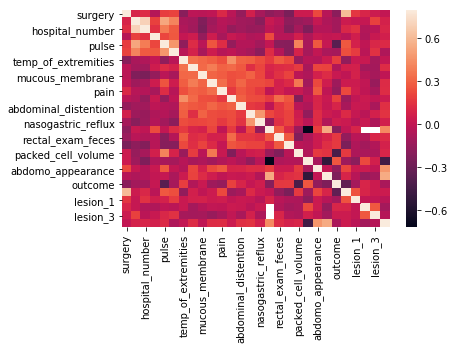

In [17]:
train_corr=clean_horse.corr()
sns.heatmap(train_corr, vmax=0.8)
corr_values=train_corr['outcome'].sort_values(ascending=False)
corr_values=abs(corr_values).sort_values(ascending=False)
print("Correlation of mentioned features wrt outcome in ascending order")
print(abs(corr_values).sort_values(ascending=False))

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


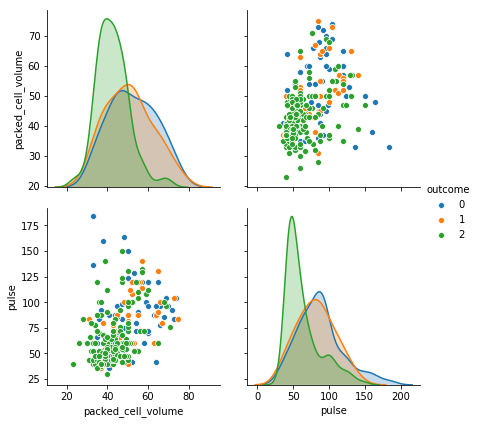

In [22]:
g = sns.pairplot(data=clean_horse, vars=['packed_cell_volume', 'pulse'], hue='outcome', size=3);

In [47]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
X = clean_horse[['packed_cell_volume','pulse','outcome']]

In [48]:
X_non_imputed = X.dropna()
y_non_imputed = X_non_imputed.outcome
X_non_imputed = X_non_imputed.drop('outcome',axis=1)
# Train the model using the training sets
regr.fit(X_non_imputed, y_non_imputed)

# Make predictions using the testing set
y_pred = regr.predict(X_non_imputed)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_non_imputed, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_non_imputed, y_pred))

Coefficients: 
 [-0.02519242 -0.00776114]
Mean squared error: 0.55
Variance score: 0.23


In [49]:
X_imputed = clean_horse[['packed_cell_volume','pulse']]
X_imputed['packed_cell_volume'] = X_imputed['packed_cell_volume'].fillna(X_imputed['packed_cell_volume'].mean())
X_imputed['pulse'] = X_imputed['pulse'].fillna(X_imputed['pulse'].mean())

# Train the model using the training sets
regr.fit(X_imputed, y)

# Make predictions using the testing set
y_pred = regr.predict(X_imputed)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

Coefficients: 
 [-0.02752577 -0.00712789]
Mean squared error: 0.59
Variance score: 0.21


In [ ]:
# add an example where you show bias increase in missing data, just a simple calculation. 
# Bias(\mu) = \E[/mu -x] - estimator's bias in this case, mean. 

**3. Most statistical tools, theoretical and applied are designed for complete datasets**

Almost all standard statistical analysis techniques and their implementations in various softwares were developed for complete datasets, and cannot handle appropriately incomplete ones (Schafer and Graham, 2002).

TODO: finish the below table with explanations

Models| Handle Missing data
---|---
Linear Regression |Yes
Neural Networks |No
Decision Trees |Yes
Random Forest |Yes

## Description and patterns of missing data

**What do you want to say here?** 

Unit vs item
Graph. 1930s polls.
Item: income

Run me!
![title](img/item-nonresponse.png)
![title](img/unit-nonresponse.png)
![title](img/univariate.png)
![title](img/monotone.png)
![title](img/non-monotone.png)

## Mechanisms of missing data
It is hard to differentiate between the first one (MCAR) and the last one (MNAR) but we'll try to show you some tricks! 

**MCAR: Missing Completely at Random**

If the missingness of the data is *unrelated* to both the observed and the unobserved data, the missing data is said to be missing completely at random (MCAR). In this situation, the missing data is a random subsample of the complete dataset. Discarding data can bias estimates and lose information

In this specific case, analyzing only the observations with complete data in the study (complete case analysis) would lead to a loss of power/efficiency in the study, but not to a higher bias in the estimates. As a rule of thumb, if less than 60% of the features of a datapoint are missing, we shouldn't remove it.

An important caveat is that MCAR and correlations are not necessarily mutually exclusive, i.e. the possibility that the missingness of a variable X is related to the missingness of some other variable Y. If in a survey the same subjects refused to answer both the age and the gender questions, this can mean both MCAR or not. 

In [ ]:
# Add something interesting here about correlations for the missing data examples

**MAR: Missing at Random** 

If missingness of the data depends only on the observed data and not on the unobserved data, we say that the data is missing at random (MAR). This implies that after taking the observed data into account, there are no systematic differences between items (subjects) with missing data and those without missing data.

In [ ]:
# Add something interesting here

**MNAR: Missing not at Random**
This occurs when the missingness of the data depends on the values of the missing data themselves. It often occurs for the income variable in surveys for example: both high income earners and low income earners are less likely to report their income (to answer the income question) than are the average income earners. Therefore the fact that those answers will be missing will be correlated to the value of those missing data points themselves. The data in such a study cannot be said to be missing at random.


Most statistical tools require data to be MAR or MCAR. However, in the presence of MNAR, the same statistical tools remain the best thing we have – just much more uncertain/unreliable.


In [ ]:
# Add something interesting here

## Visualization
As usual, we start by visualizing our missing data. 

We started deadset on sticking to a pure Python workflow. If something not implemented in Python, we would rather code it ourselves than revert to R. That’s how we roll.

It became clear over time that R keeps a tremendous advantage in esoteric statistical fields such as handling missing data. At this point in time, no robust and comprehensive python package for handling missing data. A good lesson in data science – be versatile and use whatever is available.

I will show you here the workflow by appealing to the best R packages I could find for each task.

Visualization is key. Important not only for you, but also for your audience/publications.


In [ ]:
#getwd()
data <- read.csv("../.././data/imputation_dataset_no_censoring_24022018.csv", na.strings = '', header=TRUE)
data_knn_part <- kNN(data)

matrixplot(data, labels=TRUE)

Run me!
![title](img/knn_matrixplot.png)

In [ ]:
aggr(data, prop=c(TRUE,FALSE), sortVars=TRUE, sortCombs=TRUE)

Run me! 
![title](img/knn_proportions_missing.png)

### Interlude: Is the missing data MCAR? (How to test for this)
[Baylor](https://cran.r-project.org/web/packages/BaylorEdPsych/BaylorEdPsych.pdf)
[MCAR Test Youtube](https://www.youtube.com/watch?v=LmyRcu75XEI)

If yes, great. If not, more manual investigations needed, as there is no statistical test to differentiate between MAR and MNAR. **YOU MEAN MCAR AND MNAR?**

Question: Should this part go here?


________

## R works either with Kernel or with below magic commands

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R require(ggplot)
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
%R -i df